In [32]:
######
# @:Author: Jiageng Ding
# @:Date: 2023-02-05 16:58:48
# @:Mail: jiageng.ding@gmail.com
# @:LastEditors: Jiageng Ding
# @:LastEditTime: 2023-02-05 17:02:32
# @:FilePath: /cw1/lt22041.ipynb
######

# ADFT CA1

## Data Loading

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

music_ratings = pd.read_csv('ratings_Digital_Music.csv',
                            header=None,
                            nrows=50000)

music_ratings.columns = ['user_id', 'item_id', 'rating', 'timestamp']
music_ratings.head()

,user_id,item_id,rating,timestamp
0,A2EFCYXHNK06IS,5555991584,5.0,978480000
1,A1WR23ER5HMAA9,5555991584,5.0,953424000
2,A2IR4Q0GPAFJKW,5555991584,4.0,1393545600
3,A2V0KUVAB9HSYO,5555991584,4.0,966124800
4,A1J0GL9HCA7ELW,5555991584,5.0,1007683200


## Q1: How many unique users and items in the 50,000 historical ratings?

In [34]:
n_users = music_ratings['user_id'].unique().shape[0]
n_items = music_ratings['item_id'].unique().shape[0]
n_rating = music_ratings['rating'].unique().shape[0]

print('%i unique users' % n_users)
print('%i unique items' % n_items)
print('%i unique ratings' % n_rating)

34947 unique users
1449 unique items
5 unique ratings


## Q2: Describe how you build this digital music RS by predicting ratings in detail.

1. What the model is (hint: matrix operations)
2. What the loss function is
3. Show performance visualization for the training/validation set

In [35]:
ratings = music_ratings.pivot(index='user_id',
                              columns='item_id',
                              values='rating')

ratings = ratings.fillna(0).values


In [36]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('percentage of user-items that have a rating: {:.2f}%'.format(sparsity))

percentage of user-items that have a rating: 0.10%


In [37]:
def train_test_split(ratings: np.ndarray,
                     n_ratings=35) -> tuple[np.ndarray, np.ndarray]:
    """Split ratings set to train set and validation set

    Args:
        ratings (np.ndarray): ratings matrix
        n_ratings (int): Number of ratings for a user. Defaults to 35.

    Returns:
        tuple[np.ndarray, np.ndarray]: train set and validation set
    """
    validation = np.zeros(ratings.shape)
    train = ratings.copy()

    for user in np.arange(ratings.shape[0]):

        if len(ratings[user, :].nonzero()[0]) >= n_ratings:
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0],
                size=20,
                replace=False)

            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]

    print(train.shape)
    print(validation.shape)
    return train, validation

#P is latent user feature matrix
#Q is latent item feature matrix
def prediction(P,Q):
    return np.dot(P.T,Q)

from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))


In [38]:
def train_model(ratings,
                init_rate=3.0,
                k=3,
                n_epochs=40,
                alpha=0.01,
                lmbda=0.4):
    """Train model with Collaborative Filtering

	Args:
		ratings (np.ndarray): ratings matrix
		init_rate (float, optional): Init rating for P and Q. Defaults to 3.0.
		k (int, optional): Feature number. Defaults to 3.
		n_epochs (int, optional): Number of epochs. Defaults to 40.
		alpha (float, optional): Learning rate. Defaults to 0.01.
		lmbda (float, optional): Regularization parameter. Defaults to 0.4.

	Returns:
		train_errors, val_errors: train errors and validation errors
	"""
    train, val = train_test_split(ratings)
    m, n = train.shape  # Number of users and items

    P = init_rate * np.random.rand(k, m)  # Latent user feature matrix
    Q = init_rate * np.random.rand(k, n)  # Latent movie feature matrix

    train_errors = []
    val_errors = []

    #Only consider items with ratings
    users, items = train.nonzero()
    for epoch in range(n_epochs):
        for u, i in zip(users, items):
            e = train[u, i] - prediction(
                P[:, u], Q[:, i])  # Calculate error for gradient update
            P[:, u] += alpha * (e * Q[:, i] - lmbda * P[:, u]
                                )  # Update latent user feature matrix
            Q[:, i] += alpha * (e * P[:, u] - lmbda * Q[:, i]
                                )  # Update latent item feature matrix

        P = np.nan_to_num(P)
        Q = np.nan_to_num(Q)
        train = np.nan_to_num(train)
        val = np.nan_to_num(val)

        train_rmse = rmse(prediction(P, Q), train)
        val_rmse = rmse(prediction(P, Q), val)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)

    plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data')
    plt.plot(range(n_epochs), val_errors, marker='v', label='Validation Data')
    plt.xlabel('Number of Epochs')
    plt.ylabel('RMSE')
    plt.title('Learning Curve (k = %d)' % k)
    plt.legend()
    plt.grid()
    plt.show()

    return train_errors, val_errors


(34947, 1449)
(34947, 1449)


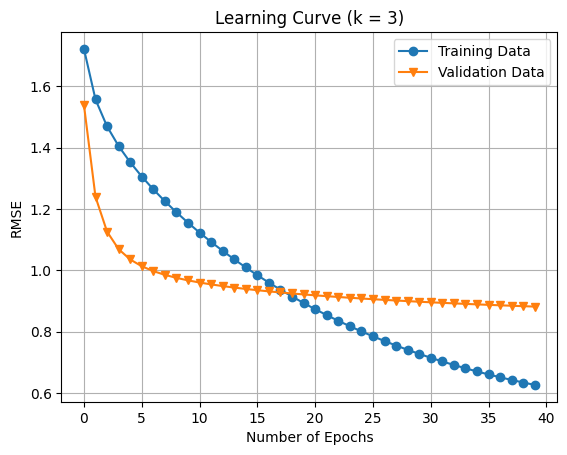

In [39]:
train_errors_k3, val_errors_k3 = train_model(ratings, k=3)

## Q3: Sensitivity analysis. The number of dimensions of user and item features would affect the prediction performance.

(34947, 1449)
(34947, 1449)


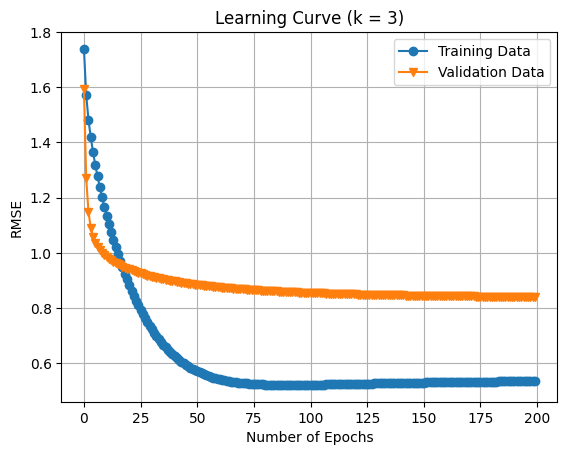

In [40]:
train_errors_k3, val_errors_k3 = train_model(ratings, k=3, n_epochs=200)

(34947, 1449)
(34947, 1449)


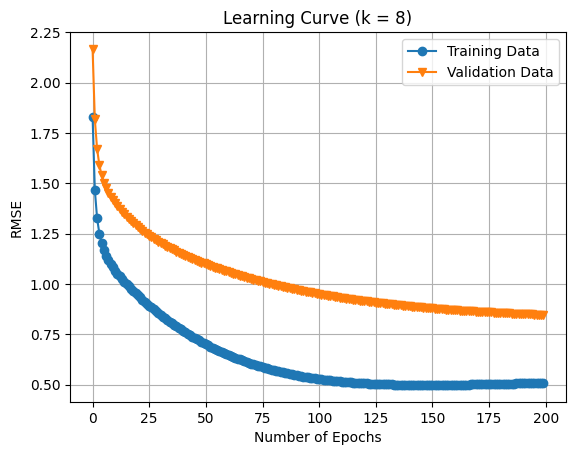

In [41]:
train_errors_k8, val_errors_k8 = train_model(ratings, k=8, n_epochs=200)

(34947, 1449)
(34947, 1449)


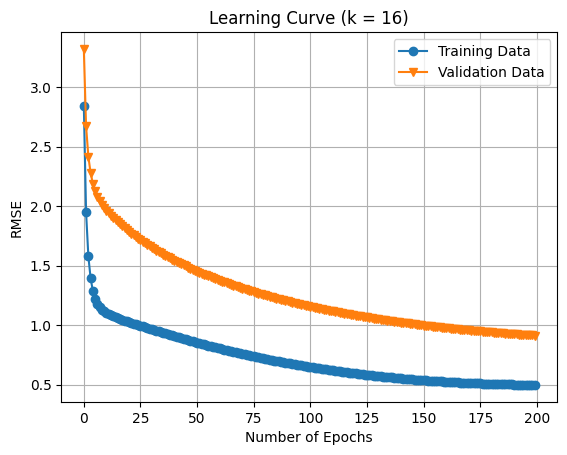

In [42]:
train_errors_k16, val_errors_k16 = train_model(ratings, k=16, n_epochs=200)

(34947, 1449)
(34947, 1449)


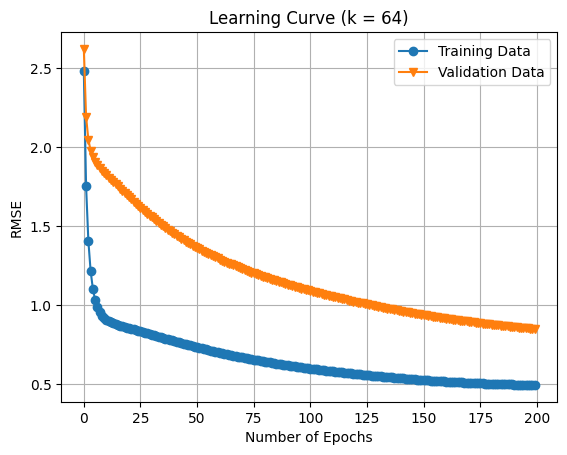

In [43]:
train_errors_k64, val_errors_k64 = train_model(ratings, k=64, init_rate=1.5, n_epochs=200)

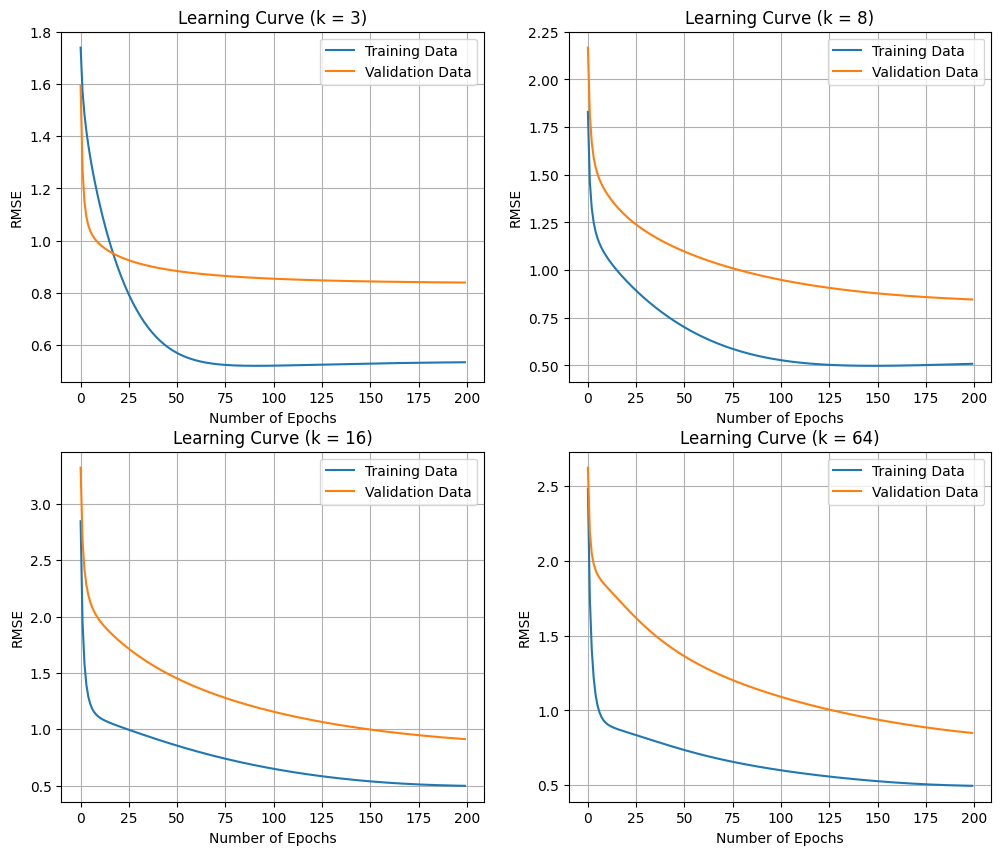

In [78]:
plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.plot(range(200), train_errors_k3, label='Training Data')
plt.plot(range(200), val_errors_k3, label='Validation Data')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.title('Learning Curve (k = 3)')

plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.plot(range(200), train_errors_k8, label='Training Data')
plt.plot(range(200), val_errors_k8, label='Validation Data')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.title('Learning Curve (k = 8)')

plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(range(200), train_errors_k16, label='Training Data')
plt.plot(range(200), val_errors_k16, label='Validation Data')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.title('Learning Curve (k = 16)')

plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.plot(range(200), train_errors_k64, label='Training Data')
plt.plot(range(200), val_errors_k64, label='Validation Data')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.title('Learning Curve (k = 64)')

plt.legend()
plt.grid()

# plt.show()

plt.subplot(2,2,1)
plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data')
plt.plot(range(n_epochs), val_errors, marker='v', label='Validation Data')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.title('Learning Curve (k = %d)' % k)
plt.legend()

[Text(0.5, 0, 'Feature number'),
 Text(0, 0.5, 'RMSE'),
 Text(0.5, 1.0, 'Validation RMSE (k = 3, 8, 16, 64)')]

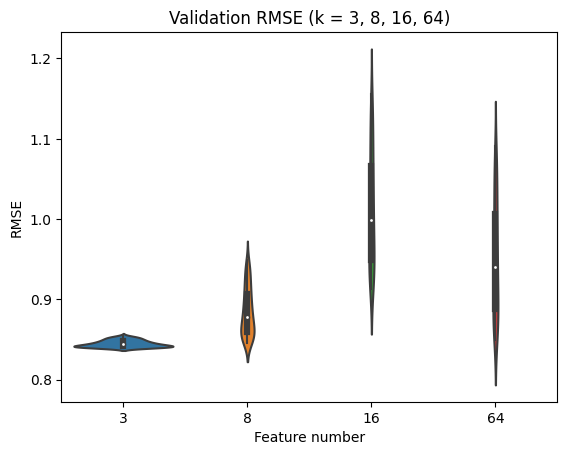

In [71]:
import seaborn as sns 

violin_fig = sns.violinplot(data=pd.DataFrame({'3':val_errors_k3[-100:], '8':val_errors_k8[-100:], '16':val_errors_k16[-100:], '64':val_errors_k64[-100:]}))
violin_fig.set(xlabel='Feature number', ylabel='RMSE', title='Validation RMSE (k = 3, 8, 16, 64)')


[Text(0.5, 0, 'Feature number'),
 Text(0, 0.5, 'RMSE'),
 Text(0.5, 1.0, 'Validation RMSE (k = 3, 8, 16, 64)')]

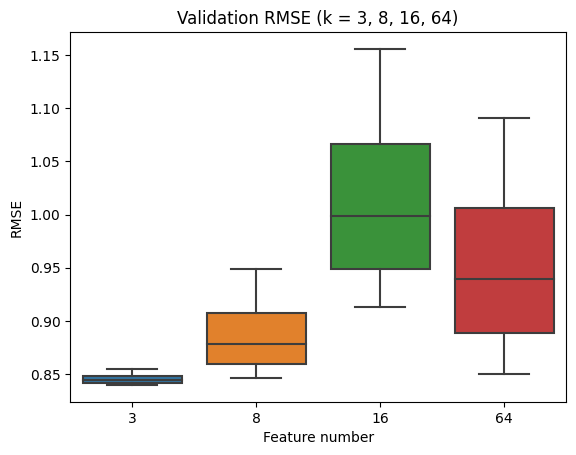

In [72]:
box_fig = sns.boxplot(data=pd.DataFrame({'3':val_errors_k3[-100:], '8':val_errors_k8[-100:],
'16':val_errors_k16[-100:], '64':val_errors_k64[-100:]}))
box_fig.set(xlabel='Feature number', ylabel='RMSE', title='Validation RMSE (k = 3, 8, 16, 64)')